# Установка библиотек

In [3]:
!pip install -U scikit-learn

   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.2 MB 1.7 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/9.2 MB 5.9 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/9.2 MB 8.3 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/9.2 MB 7.6 MB/s eta 0:00:02
   -------- ------------------------------- 1.9/9.2 MB 9.4 MB/s eta 0:00:01
   ----------- ---------------------------- 2.6/9.2 MB 9.8 MB/s eta 0:00:01
   ------------- -------------------------- 3.1/9.2 MB 9.9 MB/s eta 0:00:01
   --------------- ------------------------ 3.6/9.2 MB 10.0 MB/s eta 0:00:01
   ----------------- ---------------------- 4.1/9.2 MB 10.1 MB/s eta 0:00:01
   -------------------- ------------------- 4.6/9.2 MB 10.2 MB/s eta 0:00:01
   ---------------------- ----------------- 5.2/9.2 MB 10.3 MB/s eta 0:00:01
   ------------------------ --------------- 5.7/9.2 MB 10.3 MB/s eta 0:00:01
   -----------

In [1]:
!pip install lightgbm
!pip install phik
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install sklearn
!pip install phik
!pip install random

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 1.3 MB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.3 MB 3.4 MB/s eta 0:00:01
   -------------------- ------------------- 0.7/1.3 MB 6.1 MB/s eta 0:00:01
   ---------------------------------- ----- 1.1/1.3 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/663.4 kB ? eta -:--:--
      --------------------------------------- 10.2/663.4 kB ? eta -:--:--
     -- ---------------------------------- 41.0/663.4 kB 393.8 kB/s eta 0:00:02
     -------------- ----------------------- 256.0/663.4 kB 1.8 MB/s eta 0:00:01
     ------------------------------------ - 634.9/663.4 kB 3.3 MB/s eta 0:00:01
     -------------------------------------  655.4/663.4 kB 3.4 MB/s eta 0:00:01
     ---

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


# Импорт библиотек

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler

from phik.report import plot_correlation_matrix
# from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from random import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(20,10)})

# Загружаем наши данные после прошлой сессии

In [ ]:
# Загружаем данные
total_data_ready = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_2/total_ready.csv')

# Формирование дополнительных атрибутов

In [ ]:
uniq_region = total_data_ready['region'].unique()
uniq_region

array(['Барнаул', 'Немецкий национальный район', 'Шипуновский район', ...,
       'Переславский район', 'Ярославский район', 'Борисоглебский район'],
      dtype=object)

In [ ]:
# Смотрим количество уникальных регионов в нашем датасете
len(uniq_region)

2282

Для работы с нашими данными мы создадим признаки, которые помогут решить поставленню задачу: danger_level - уровень опасности адреса, который составляется при помощи формулы, использующую сложности ДТП, количество инцидентов по региону и инцедентов по адресу; total_incidents_region - количество инцидентов по региону; total_incidents_address - количество инцидентов по адресу; severity_num - сложность ДТП в цифрах, month - месяц, в который произошло ДТП.

Ниже приведены функции, которые создадут нам описанные выше признаки:

In [ ]:
def total_incidents_on_region(row):
    region = row['region']
    return total_data_ready[total_data_ready['region'] == region]['id'].count()

def total_incidents_on_address(row):
    region = row['region']
    address = row['address']
    return total_data_ready[(total_data_ready['address'] == address) & (total_data_ready['region'] == region)]['id'].count()

def severity_to_number(value):
    if value == 'Легкий':
        return 3
    elif value == 'Тяжёлый':
        return 2
    else:
        return 1

def danger_level_value(row):
    severity_num = row['severity_num']
    total_incidents_region = row['total_incidents_region']
    total_incidents_address = row['total_incidents_address']
    dead_count = row['dead_count']
    injured_count = row['injured_count']
    participants_count = row['participants_count']

    danger_level = (2**(abs(severity_num-3)) * (total_incidents_address/total_incidents_region))/total_incidents_region
    return danger_level

Функции созданы, значит мы можем приступить к их использованию - добавим признаки в нашу таблицу (ремарка - мы создаем дополнительные два столбца: frequency и month, так как они также могут нам помочь в дальнейшем прогнозе):

In [ ]:
total_data_ready['total_incidents_region'] = total_data_ready.apply(total_incidents_on_region, axis=1)
total_data_ready['total_incidents_address'] = total_data_ready.apply(total_incidents_on_address, axis=1)
total_data_ready['severity_num'] = total_data_ready['severity'].apply(severity_to_number)
total_data_ready['danger_level'] = total_data_ready.apply(danger_level_value, axis=1)
total_data_ready['frequency'] = total_data_ready['total_incidents_address']/total_data_ready['total_incidents_region']
total_data_ready['month'] = total_data_ready.datetime.dt.month
total_data_ready.head()

Все признаки созданы, таблица наполнилась новыми столбцами, которые помогут нам в прогнозе опасности дорог. Однако давайте проверим наши главные признаки - danger_level и total_incidents_address. Необходимость их проверки заключается в том, что данный признак создавался с применением математической функции, которую мы сами составили, поэтому нужно убедиться в рациональности значений (danger_level), а признак total_incidents_address может содержать выбросы, если дорога была записана одинакова в некоторых местах:

In [ ]:
total_data_ready.danger_level.describe()

count    6.153200e+04
mean     1.128435e-04
std      8.104723e-03
min      1.108967e-08
25%      1.774347e-07
50%      2.381244e-06
75%      2.898287e-05
max      2.000000e+00
Name: danger_level, dtype: float64

In [ ]:
total_data_ready.total_incidents_address.describe()

count    61532.000000
mean         8.197036
std         41.155005
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        456.000000
Name: total_incidents_address, dtype: float64

В глаза бросатеся максимальное значение - 2. Остальные данные лежат в приемлемых границах - каждая 25% данных разнится от соседей умножением на 10, но максимальное значение в сравнении с другими похоже на выброс. Скорее всего это связано с тем, что (согласно нашей формуле составления danger_level) частота ДТП на выбранной улице огромная, а общее количество ДТП по региону низкое. Также стоит заметить, что у нас есть явный выброс в 390 ДТП по адресу, хотя 3 квантиль равен 4. Давайте проверим данное рассуждение просмотром строки максимального уровня опасности и просмотром количества ДТП по адресам без адреса с 390 происшествиями:

In [ ]:
total_data_ready[total_data_ready['danger_level'] == total_data_ready['danger_level'].max()]

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,total_incidents_region,total_incidents_address,severity_num,danger_level,frequency,month
34990,2221936,Дорожно-транспортные происшествия,Светлое время суток,,Новая Земля,"Прочие автомобильные дороги (ведомственные), 1 км",Пасмурно,Опрокидывание,2017-07-23 17:30:00,Тяжёлый,0,1,Архангельская область,Мокрое,2,Все участники,71.5572,52.3364,1,1,2,2.0,1.0,7


In [ ]:
total_data_ready[total_data_ready.total_incidents_address < 390].total_incidents_address.describe()

count    61076.000000
mean         4.853690
std         14.071877
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        146.000000
Name: total_incidents_address, dtype: float64

Количество ДТП по региону равно 1, количество ДТП по адресу также равно 1, а тяжесть ДТП равна 2, то есть тяжелое ДТП. Именно благодаря таким данным и получился выброс в виде 2. Нам такое значение не нужно по причине вреда на остальные данные при составлении и обучении моделей, поэтому мы просто уберем данную строку из таблицы. Также оставим в значение количества ДТП на уровне 133 и не более:

In [ ]:
total_data_ready = total_data_ready.query('danger_level != 2')

In [ ]:
total_data_ready = total_data_ready[total_data_ready.total_incidents_address < 390]

Следующий график покажет нам, насколько сильна зависимость признака severity к danger_level:

In [ ]:
sns.boxplot(x="severity", y="danger_level", data=total_data_ready[total_data_ready['danger_level'] < 0.006])

Все как и ожидалось - чем выше тяжесть ДТП, тем выше уровень опасности дороги. Далее на очереди график с анализом самого опасного месяца. Зависимость следующая: признак month к признаку danger_level:

In [ ]:
sns.boxplot(x="month", y="danger_level", data=total_data_ready[total_data_ready['danger_level'] < 0.00015])

Самым опасным месяцем оказался июль, второй - август и завершает тройку июнь. Это полностью соответсвуют погоде, которая происходила чаще всего во время ДТП - ясная. Это еще раз доказывает нам, что чаще всего в ДТП виноваты обычные водители.

Теперь посмотрим, какая тяжесть ДТП происходила чаще по адресам:

In [ ]:
sns.boxplot(x="severity", y="total_incidents_address", data=total_data_ready[total_data_ready['total_incidents_address'] < 80])

KeyError: ignored

Опять же, все логично - чаще всего на количество ДТП по определенным адресам происходит ДТП легкой тяжести, остальные с одинаковой частотой. Также мы убрали сильные выбросы с данных

Этап визуализации завершен, а значит мы можем сделать некие выводы:

Количество раненных в ДТП больше всего в тяжелом ДТП;
ДТП чаще всего происходят в ясную погоду;
Самые опасные месяцы: июль, август и июнь - 3 месяца лета.

# Выделение данных для кластеризации

Следующим этапом в нашей работе будет подготовка к кластеризации. Кластеризация - процесс разбиения данных на кластеры (классы), данные которых объединяются по каким-то схожим признакам. Позволяет перейти от обучения без учителя к обучению с учителем (мы создадим целевой признак).

Для того чтобы начать кластеризацию, мы возьмем наиболее важные признаки для составления классов уровня опасности дороги. Однако первым делом мы приведем категориальные признаки в числовой вид, чтобы использовать их в будущем:

In [ ]:
cat_col = ['light','weather','category','road_conditions','participant_categories']
encoder = LabelEncoder()

total_data_ready[cat_col] = total_data_ready[cat_col].apply(encoder.fit_transform)
total_data_ready.head()

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,total_incidents_region,total_incidents_address,severity_num,danger_level,frequency,month
0,2311491,Дорожно-транспортные происшествия,2,Многоквартирные жилые домаАдминистративные зда...,Барнаул,"г Барнаул, тракт Павловский, 249 а",21,10,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,1032,2,4,53.342000,83.690300,9496,1,3,1.108967e-08,0.000105,9
1,2589161,Дорожно-транспортные происшествия,4,Остановка общественного транспортаНерегулируем...,Барнаул,"г Барнаул, ул Малахова, 46",21,16,2021-06-29 16:45:00,Легкий,0,1,Алтайский край,1213,3,4,53.369700,83.709200,9496,24,3,2.661521e-07,0.002527,6
2,2577125,Дорожно-транспортные происшествия,0,Жилые дома индивидуальной застройкиАдминистрат...,Барнаул,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",21,10,2021-05-30 21:40:00,Тяжёлый,0,1,Алтайский край,1032,1,11,53.264995,83.725905,9496,12,2,2.661521e-07,0.001264,5
3,2576909,Дорожно-транспортные происшествия,4,Выезд с прилегающей территорииАдминистративные...,Барнаул,"г Барнаул, ул Петра Сухова, 83 А",21,16,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,1161,3,11,53.376400,83.714200,9496,2,2,4.435868e-08,0.000211,5
4,2575209,Дорожно-транспортные происшествия,4,Многоквартирные жилые домаЖилые дома индивидуа...,Барнаул,"г Барнаул, ул Партизанская, 26",21,16,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,1213,2,4,53.343071,83.794366,9496,1,3,1.108967e-08,0.000105,5


Данные приведены в числовой вид, а значит можно выделить наиболее важные признаки для составления классов опасности дорог. Предлагается выделить признаки total_incidents_address, danger_level и frequency ( id необходим для будущего объединения таблиц по схожему признаку):

In [ ]:
data_for_models = total_data_ready[['id', 'total_incidents_address','danger_level', 'frequency']]
print(data_for_models.shape)

(61075, 4)


In [ ]:
data_for_models.head()

,id,total_incidents_address,danger_level,frequency
0,2311491,1,1.108967e-08,0.000105
1,2589161,24,2.661521e-07,0.002527
2,2577125,12,2.661521e-07,0.001264
3,2576909,2,4.435868e-08,0.000211
4,2575209,1,1.108967e-08,0.000105


Данные готовы для кластеризации - были выделены наиболее важные для составления классов опасности дорог

# Кластеризация набора данных

Кластеризация бывает разной: когда мы знаем заранее сколько классов мы создадим и когда не знаем, но пытаемся понять. Поэтому первым действием мы составим график локтя. График локтя это специальный метод, который показывает сколько кластеров стоит использовать. Процесс состоит в том, что при определенном количестве кластеров мы считаем сумму квадратов расстояний от элемента до ближайшего центра кластера, то есть если у нас есть всего один кластер, то расстояние от выброса до центра будет огромным, что нелогично для разделения данных по классам - нужно уменьшать расстояние до центра, но при этом не создавать слишком много классов, чтобы не терять логику этих самых классов.

Для составления локтя мы воспользуемся методом Kmeans с количеством кластеров от 1 до 10:

In [ ]:
wcss = []
for clusters in range(1, 11):

    model = KMeans(n_clusters=clusters, max_iter=300, n_init=10, random_state=45)
    model.fit(data_for_models.drop('id', axis=1))

    wcss.append(model.inertia_)

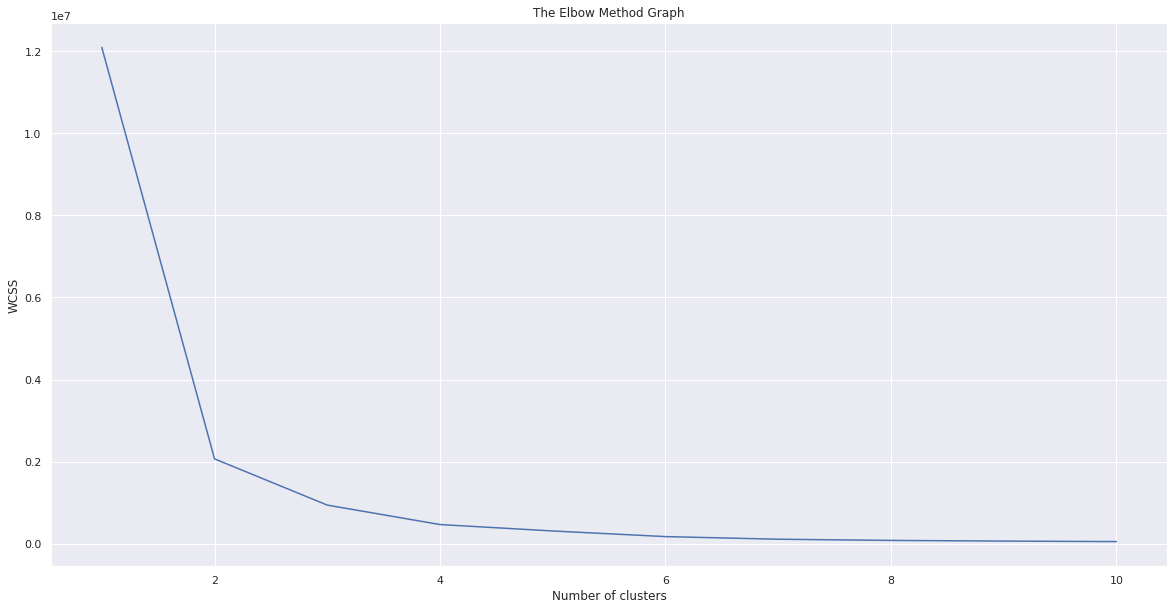

In [ ]:
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

По графику можно заметить, как сильно меняется график при обновлении количества классов. Чем острее угол, тем сильнее меняется график и, соответственно, такое количество классов нам приемлемо. Однако если угол становится сильно тупым, то мы вынуждены не рассматривать то количество классов, при котором угол стал тупым.

На графике выше мы выделили 4 кластера, с ним и продолжим работу. Давайте инициализируем метод Kmeans с 4 кластерами и обучим его:

In [ ]:
model = KMeans(n_clusters=4, max_iter=300, n_init=10, random_state=45)
data_for_models['clusters'] = model.fit_predict(data_for_models.drop('id', axis=1))

<ipython-input-47-6f20e2ba2a9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_models['clusters'] = model.fit_predict(data_for_models.drop('id', axis=1))


Давайте посмотрим, какие классы имеют при себе наибольшее количество элементов:

In [ ]:
data_for_models.clusters.value_counts()

0    54052
3     5901
1      638
2      484
Name: clusters, dtype: int64

распределение данных выглядит хорошим: у нас тут есть и преобладающий класс, и сильно малый. Однако давайте проверим как ситуация обстоит в уровне опасности дорог по каждому кластеров:

In [ ]:
print("Максимальный уровень опасности дороги в кластере 0:", data_for_models[data_for_models.clusters == 0]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 1:", data_for_models[data_for_models.clusters == 1]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 2:", data_for_models[data_for_models.clusters == 2]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 3:", data_for_models[data_for_models.clusters == 3]['danger_level'].max())

Максимальный уровень опасности дороги в кластере 0: 0.046875
Максимальный уровень опасности дороги в кластере 1: 0.00015360978667585244
Максимальный уровень опасности дороги в кластере 2: 0.001491970486111111
Максимальный уровень опасности дороги в кластере 3: 0.06925207756232687


Самый опасный кластер - 0, самый безопасный - 3. Давайте зададим цвета и отобразим на графике наши данные: количество инцидентов по адресу на уровень опасности дороги:

In [ ]:
data_for_graphic = data_for_models.copy()

In [ ]:
# centroids = model.cluster_centers_

# cen_x = [i[0] for i in centroids]
# cen_y = [i[1] for i in centroids]

# data_for_graphic['center_x'] = data_for_graphic.clusters.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})#, 4:cen_x[4]})
# data_for_graphic['center_y'] = data_for_graphic.clusters.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})#, 4:cen_y[4]})
colors = [ 'red', 'darkgreen', 'lightgreen', 'yellow']#, '#93df20'], '#46df20']
data_for_graphic['color'] = data_for_graphic.clusters.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})#, 4:colors[4]})

# plt.scatter(data_for_models['cluster'==0, 0], data_for_models['cluster'==0, 1], s=100, c='red', label ='Cluster 1')
# plt.scatter(data_for_models['cluster'==1, 0], data_for_models['cluster'==1, 1], s=100, c='blue', label ='Cluster 2')
# plt.scatter(data_for_models['cluster'==2, 0], data_for_models['cluster'==2, 1], s=100, c='green', label ='Cluster 3')

Text(0, 0.5, 'Уровень опасности дороги')

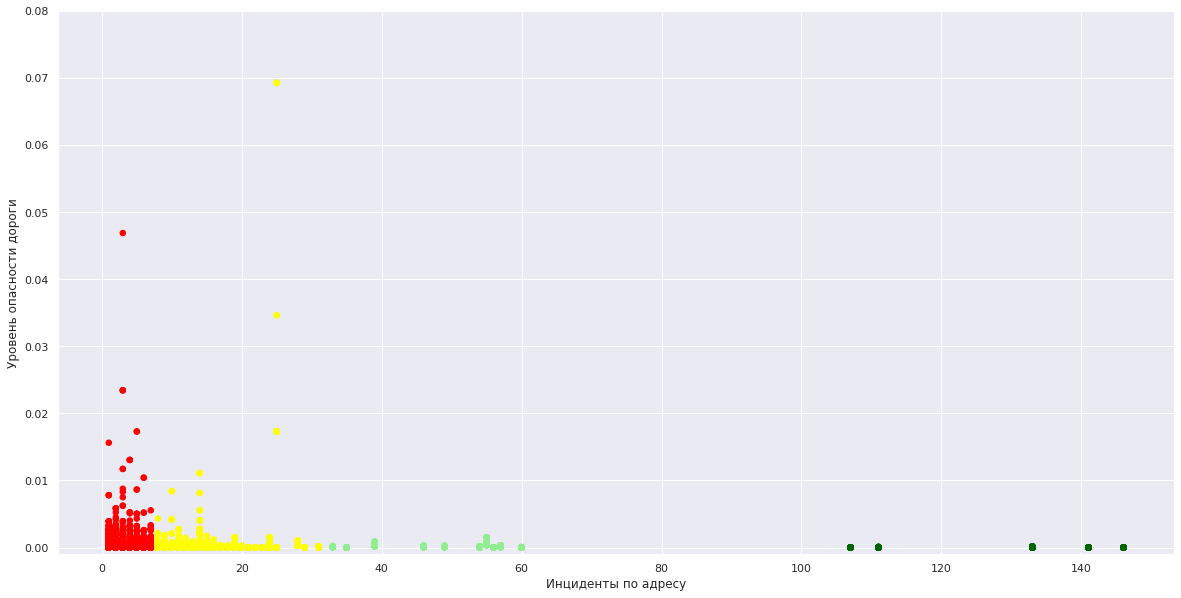

In [ ]:
plt.scatter(data_for_graphic.total_incidents_address, data_for_graphic.danger_level, c=data_for_graphic.color, s=30)
plt.ylim(-0.001, 0.08)
plt.xlabel('Инциденты по адресу')
plt.ylabel('Уровень опасности дороги')

# centroids = pd.DataFrame(model.cluster_centers_, columns=data_for_models.columns)
# # Добавление столбца с номером кластера
# data_for_models['label'] = model.labels_.astype(str)
# centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']
# # Сброс индекса понадобится дальше
# data_all = pd.concat([data_for_models, centroids], ignore_index=True)

# # Построение графика
# sns.pairplot(data_all, hue='label', diag_kind='hist')

Данные в ужасном виде: Kmeans разделил данные по количеству инцидентов на адрес, что в корне неверно - разделение данных должно было опираться на три признака, а не только на один. Давайте проверим следующий метод класстеризации - гаусовсская кластеризация. Здесь мы также воспользуемся данными, которые строили нам Kmeans и количество кластеров то же - 4:

In [ ]:
gaussian_data = data_for_models.drop('clusters', axis=1).copy()
gaussian_data.head(2)

,id,total_incidents_address,danger_level,frequency
0,2311491,1,1.108967e-08,0.000105
1,2589161,24,2.661521e-07,0.002527


In [ ]:
gm = GaussianMixture(n_components=4, random_state=0).fit(gaussian_data.drop('id', axis=1))
gaussian_data['clusters'] = gm.predict(gaussian_data.drop('id', axis=1))
gaussian_data['clusters'].value_counts()

0    33096
3    24213
1     3660
2      106
Name: clusters, dtype: int64

Распределение значений по кластерам крайне интересное: у нас здесь два почти одинаковых по набору элементов кластеров и один крайне малый, что верно. Давайте проверим максимальные значения в каждом кластере:

In [ ]:
print("Максимальный уровень опасности дороги в кластере 0:", gaussian_data[gaussian_data.clusters == 0]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 1:", gaussian_data[gaussian_data.clusters == 1]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 2:", gaussian_data[gaussian_data.clusters == 2]['danger_level'].max())
print("Максимальный уровень опасности дороги в кластере 3:", gaussian_data[gaussian_data.clusters == 3]['danger_level'].max())

Максимальный уровень опасности дороги в кластере 0: 0.000248000496000992
Максимальный уровень опасности дороги в кластере 1: 0.004162330905306971
Максимальный уровень опасности дороги в кластере 2: 0.06925207756232687
Максимальный уровень опасности дороги в кластере 3: 0.0034602076124567475


Самый опасный кластер - 0, самый безопасный - 2. Данные распределены в более разбросанном виде, что немного радует, давайте теперь отобразим все на графике:

In [ ]:
gaussian_data_for_graphic = gaussian_data.copy()

In [ ]:
colors = [ 'red', 'yellow', 'lightgreen', 'darkgreen']#, 'lightgreen', 'yellow', 'red']
gaussian_data_for_graphic['color'] = gaussian_data_for_graphic.clusters.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})#, 4:colors[4]})

Text(0, 0.5, 'Уровень опасности дороги')

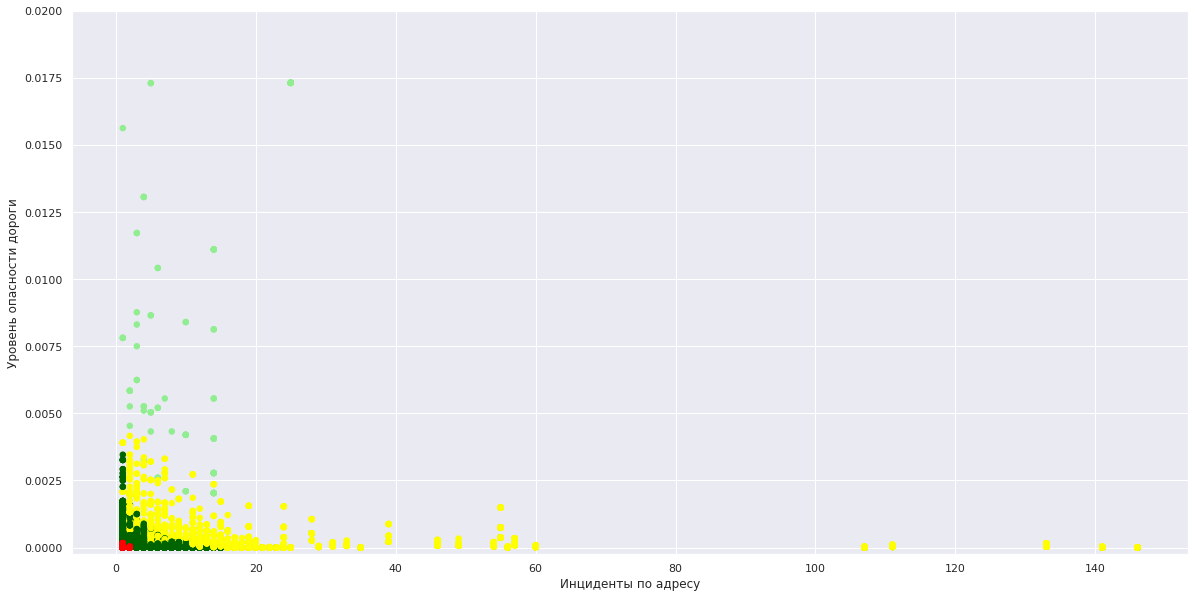

In [ ]:
plt.scatter(gaussian_data_for_graphic.total_incidents_address,
            gaussian_data_for_graphic.danger_level,
            c=gaussian_data_for_graphic.color, s=30)
plt.ylim(-0.00025, 0.02)
plt.xlabel('Инциденты по адресу')
plt.ylabel('Уровень опасности дороги')

Распределение значений на графике отличное - все кластеры лежат аккуратно друг за другом, что говорит нам о том, что кластеризатор справился со своей целью. Те значения, которые смешиваются со значениями другого класса показывают нам о значениях в других признаках - кластеризатор составляет классы не на основе одного признака, а на основе всех.

Следующим действием будет объединение данных с итоговой выборкой, но под другой переменной:

In [ ]:
total_data_clusters = total_data_ready.copy()
total_data_clusters = total_data_clusters.merge(gaussian_data_for_graphic, on=['id','total_incidents_address','danger_level','frequency'])
total_data_clusters.head()

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long,total_incidents_region,total_incidents_address,severity_num,danger_level,frequency,month,clusters,color
0,2311491,Дорожно-транспортные происшествия,2,Многоквартирные жилые домаАдминистративные зда...,Барнаул,"г Барнаул, тракт Павловский, 249 а",21,10,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,1032,2,4,53.342000,83.690300,9496,1,3,1.108967e-08,0.000105,9,0,red
1,2589161,Дорожно-транспортные происшествия,4,Остановка общественного транспортаНерегулируем...,Барнаул,"г Барнаул, ул Малахова, 46",21,16,2021-06-29 16:45:00,Легкий,0,1,Алтайский край,1213,3,4,53.369700,83.709200,9496,24,3,2.661521e-07,0.002527,6,1,yellow
2,2577125,Дорожно-транспортные происшествия,0,Жилые дома индивидуальной застройкиАдминистрат...,Барнаул,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",21,10,2021-05-30 21:40:00,Тяжёлый,0,1,Алтайский край,1032,1,11,53.264995,83.725905,9496,12,2,2.661521e-07,0.001264,5,3,darkgreen
3,2576909,Дорожно-транспортные происшествия,4,Выезд с прилегающей территорииАдминистративные...,Барнаул,"г Барнаул, ул Петра Сухова, 83 А",21,16,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,1161,3,11,53.376400,83.714200,9496,2,2,4.435868e-08,0.000211,5,0,red
4,2575209,Дорожно-транспортные происшествия,4,Многоквартирные жилые домаЖилые дома индивидуа...,Барнаул,"г Барнаул, ул Партизанская, 26",21,16,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,1213,2,4,53.343071,83.794366,9496,1,3,1.108967e-08,0.000105,5,0,red


In [ ]:
total_data_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61075 entries, 0 to 61074
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       61075 non-null  int64         
 1   tags                     61075 non-null  object        
 2   light                    61075 non-null  int64         
 3   nearby                   61075 non-null  object        
 4   region                   61075 non-null  object        
 5   address                  61075 non-null  object        
 6   weather                  61075 non-null  int64         
 7   category                 61075 non-null  int64         
 8   datetime                 61075 non-null  datetime64[ns]
 9   severity                 61075 non-null  object        
 10  dead_count               61075 non-null  int64         
 11  injured_count            61075 non-null  int64         
 12  parent_region            61075 n

In [ ]:
total_data_clusters.clusters.value_counts()

0    33096
3    24213
1     3660
2      106
Name: clusters, dtype: int64


Два столбца были добавлены по своим местам - по связи столбца id, а это значит что у нас полностью готовая таблица для обучения моделей машинного обучения. Также количество значений в кластере осталось тем же, значит копирование данных прошло успешно.

In [ ]:
# Save our new dataset from 5 first regions
from google.colab import files
total_data_clusters.to_csv("total_5_regions.csv", index=False)
files.download("total_5_regions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Разбиение данных

# Подбор наиболее коррелируемых признаков

Для составления моделей машинного обучения и их последующего обучения, необходимо выбрать те признаки, которые наиболее точно позволят предсказать класс опасности дороги. Именно поэтому мы рассмотрим корреляционную матрицу признаков. Возьмем те признаки, которые имеет смысл использовать для прогноза класса (регион в котором произошло ДТП, к примеру, мы брать не будем - возможны блики в данных, из-за которых мы будем получать либо неверные результаты, либо переобучение моделей):

In [ ]:
features_target = total_data_clusters[['light','weather','category','dead_count','injured_count','road_conditions','participants_count']]

Корреляционная матрица требует, чтобы мы сразу указали признаки, которые являются интервальными - имеют огромное количество значений. Наименования данных признаков мы запишем в отдельной переменной и используем при создании матрицы:

/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable road_conditions is large: 1287. Are you sure this is not an interval variable? Analysis for pairs of variables including road_conditions can be slow.
  warnings.warn(


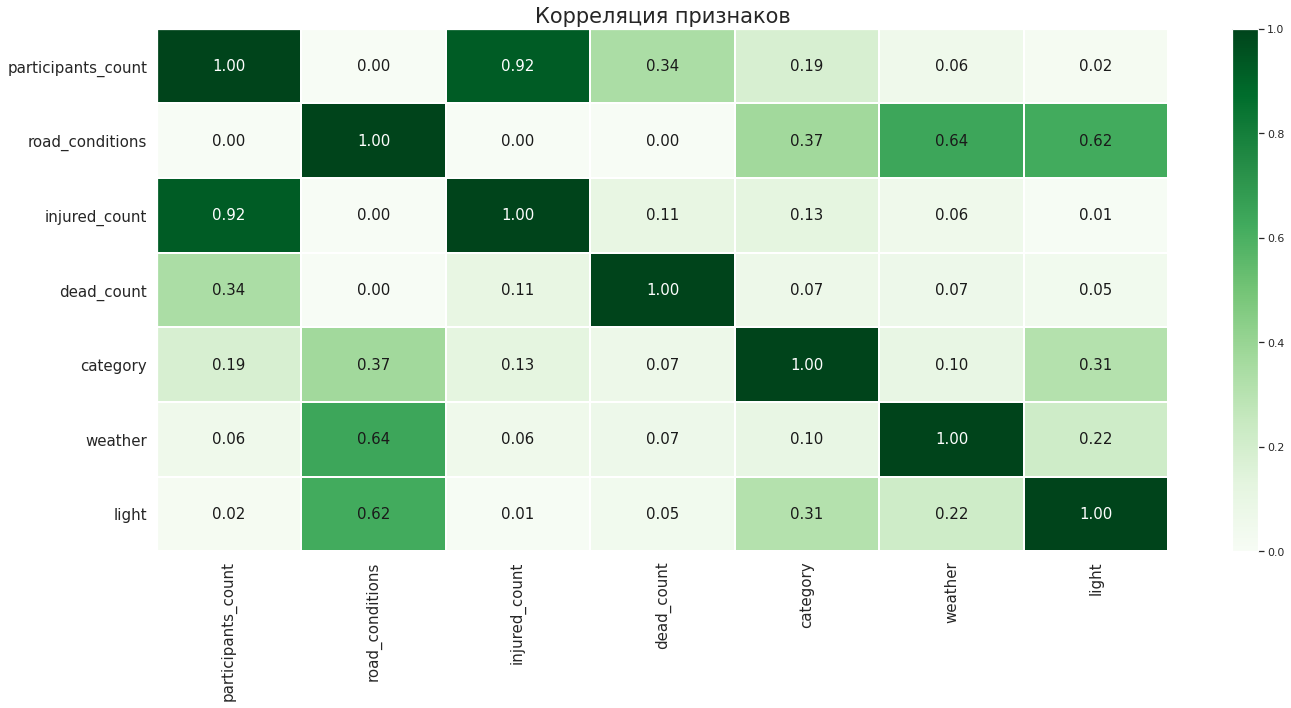

In [ ]:
interval_cols = ['dead_count','injured_count','participants_count','total_incidents_region', 'total_incidents_address', 'danger_level', 'frequency']
phik_overview = features_target.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Корреляция признаков",
                        fontsize_factor=1.5,
                        figsize=(20, 10))
plt.tight_layout()

Как можно заметить по матрице - признаки total_incidents_addres, danger_level и frequency больше всего коррелируют к нашим классам - их и возьмем в обучение модели. Однако стоит отметить один важный момент - frequency это деление total_incidents_addres на total_incidents_region, то есть связь между ними очень сильная, что может повлечь за собой проблему бликов и подглядыванию модели в ответы, поэтому признаки, от которых зависит данный признак мы не можем брать в обучение (также из-за слишком большой корреляции к clusters).

В итоге у нас два признака: frequency и danger_level, которые мы будем использовать при прогнозе класса опасности дорог.

# Создание выборок

Перед обучением создадим выборки, на который мы и будем обучать, и проверять качество моделей в целом.

Первым делом мы разделим данные на обучающую и валидационную выборки с процентным соотношением 80/20:

In [1]:
most_corr_col = ['danger_level', 'frequency']#, 'total_incidents_address']#
features_train, features_valid, target_train, target_valid = train_test_split(features_target[most_corr_col], features_target['clusters'], test_size=0.20, random_state=69)
print(features_train.shape, features_valid.shape)

NameError: name 'train_test_split' is not defined

Также стоит отметить, что в наших данных была проблема размерности классов: классы 1 и 0 содержат крайне много значений, а вот 2 и, тем более, 3 совсем чуть-чуть. Давайте отобразим на графике их размеры:

In [ ]:
target_train.plot(kind='hist', title='Размерность классов')

NameError: ignored

Что и требовалось доказать - класс 0 вообще не видно, оно и верно, во всем датасете их всего 110 штука. Для решения данной проблемы в моделях мы добавим аргумент баланса классов на balanced

# Выводы

В ходе всей работы мы провели много действий, которые привели нас к заключительной части - выводу. Хотелось бы вспомнить, что было сделано:

загружены данные с официального сайта dtp-stat.ru
данные были предобработаны: извлечены со словарей и списков, заменены типы данных и проверены на уникальность аварий
введены новые признаки, которые дали нам лучшее представление о самих ДТП
визуализированы зависимости данных друг к другу
выполнена кластеризация данных, с применением двух моделей кластеризации: Kmeans и GaussianMixture, в результате чего мы получили четыре класса опасности дорог
составлена интерактивная карта по тем данным, которые были в нашей выборке после парсинга
найдены наиболее коррелируемые данные к нашим кластерам
обучены три модели машинного обучения: LGBMClassifier, LogisticRegression и RandomForestClassifier, после которого были получены результаты и выявлена лучшая модель - LogisticRegression
В заключении нужно сказать, что модель логистической регрессии выбрана только из-за того, что в ней не было бликов данных, которые присутствовали в случайном лесе и градиентном бустинге.